In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
import scipy.signal
import pandas as pd
from helper_code import *
import numpy as np, os, sys, joblib
import ecg_plot
import pandas as pd
from glob import glob
import os
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tsai.all import *
import torch
import transformation_funcs as tfs
import imp
torch.cuda.set_device(7) 

def snomedConvert(label_df,snomed=True):
    codes =  pd.read_csv("data/snomed_codes.csv",sep=",")[["Dx","SNOMEDCTCode"]]
    if snomed:
        label_df.columns = [codes[codes["SNOMEDCTCode"] == int(x)]["Dx"].item() for x in label_df.columns]
        return label_df
DATASET_ID = "CPSC2018"
# DATASET_ID = "ChapmanShaoxing"
DATASET_NAME = "WFDB_%s_signitured"%DATASET_ID
X = np.load('./data/big_numpy_datasets/%s.npy'%DATASET_NAME, mmap_mode='c')
label_df = pd.read_csv("data/%s.csv"%DATASET_NAME).drop(columns=["headers","leads"])
y = snomedConvert(label_df)

X = X.astype(float)
y = y


/home/amirsalimi/miniconda3/envs/ecg_augment/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


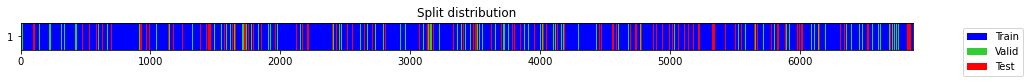

Counts by label: {'right bundle branch block': 1857, 'sinus rhythm': 918, 'atrial fibrillation': 1221, 'ventricular ectopics': 700, 'st depression': 869, 'left bundle branch block': 236, 'st elevation': 220, '1st degree av block': 722, 'premature atrial contraction': 616}


In [3]:

cv_splits = get_splits(y.to_numpy(), n_splits =1, valid_size=.1,test_size=0.1, stratify=False, random_state=23, shuffle=True)
y_multi = []
for i,row in y.iterrows():
    sample_labels = []
    for i,r in enumerate(row):
        if r == True:
            sample_labels.append(y.columns[i])
        
    y_multi.append(list(tuple(sample_labels)))
label_counts = collections.Counter([a for r in y_multi for a in r])
print('Counts by label:', dict(label_counts))

# Test out transformations after dataloading here (slower)

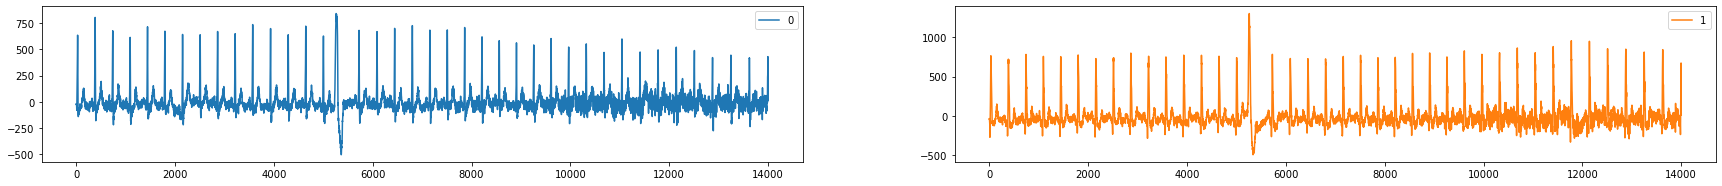

In [4]:
# %%time
sf = 0.5
tfms  = [None, TSMultiLabelClassification()]
batch_tfms = [
             TSStandardize(by_sample=True),
                # tfs.BandPass(500,3,100),
                # tfs.Scale(scale_factor=sf,mode="nearest"),
                # tfs.Normalize(),
              # tfs.RandomShift(0.1),
#               tfs.MulNoise(6),
#               tfs.CutOutWhenTraining(),
             ]
dsets = TSDatasets(X.astype(float), y_multi, tfms=tfms, splits=cv_splits) # inplace=True by default
dls   = TSDataLoaders.from_dsets(dsets.train,dsets.valid, bs=[64, 128], batch_tfms=[], num_workers=0,shuffle_train=False,)
dls_transformed   = TSDataLoaders.from_dsets(dsets.train,dsets.valid, bs=[64, 128], batch_tfms=batch_tfms, num_workers=0,shuffle_train=False,)
for batch in dls.train:
    b = batch
x = b[0][0]
b[1][0]
fig = pd.DataFrame(x.cpu()[0:2]).T.plot.line(subplots = True,layout=(6,2), figsize=(30,20))

In [5]:
i = 0
for batch in dls_transformed.train:
    i+=1
    print(i,end="\r")
    b = batch
x = b[0][0]
b[1][0]
# fig = pd.DataFrame(x.cpu()[0:2]).T.plot.line(subplots = True,layout=(6,2), figsize=(30,20))

TensorMultiCategory([0., 0., 0., 0., 0., 0., 0., 0., 1.], device='cuda:7')

# direct transformations on individual arrays (faster)

## normalization methods
- minmax
- maxdiv
- zscore
- median
- decimal scaling
- tanh
- double sigmoid

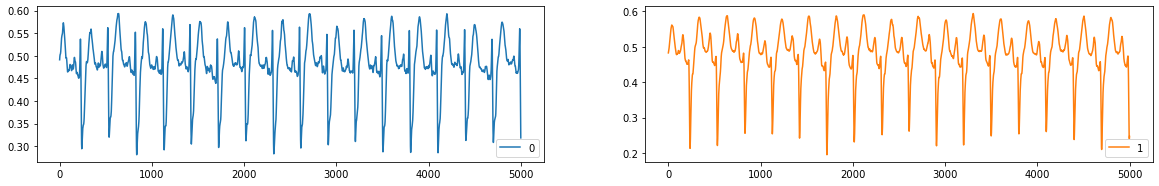

In [31]:
## minmax
ecg_tensor = TSTensor(X[0:16,:,0:5000])
ecg_tensor = tfs.NormMinMax()(ecg_tensor)
fig = pd.DataFrame(ecg_tensor[0,0:2]).T.plot.line(subplots = True,layout=(6,2), figsize=(20,20))

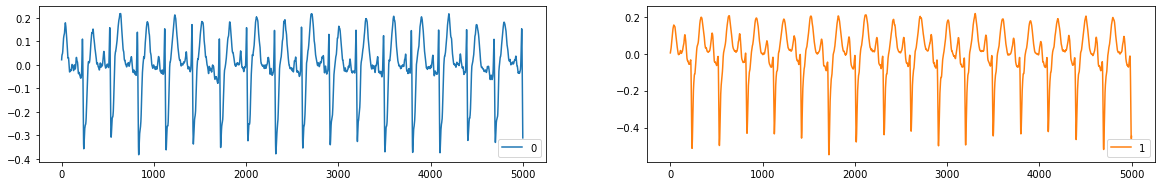

In [34]:
## maxdiv
ecg_tensor = TSTensor(X[0:16,:,0:5000])
ecg_tensor = tfs.NormMaxDiv()(ecg_tensor)
fig = pd.DataFrame(ecg_tensor[0,0:2]).T.plot.line(subplots = True,layout=(6,2), figsize=(20,20))

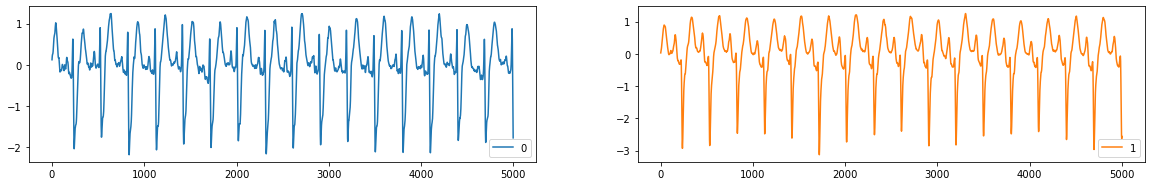

In [45]:
## Z score
ecg_tensor = TSTensor(X[0:16,:,0:5000])
ecg_tensor = tfs.NormZScore()(ecg_tensor)
fig = pd.DataFrame(ecg_tensor[0,0:2]).T.plot.line(subplots = True,layout=(6,2), figsize=(20,20))

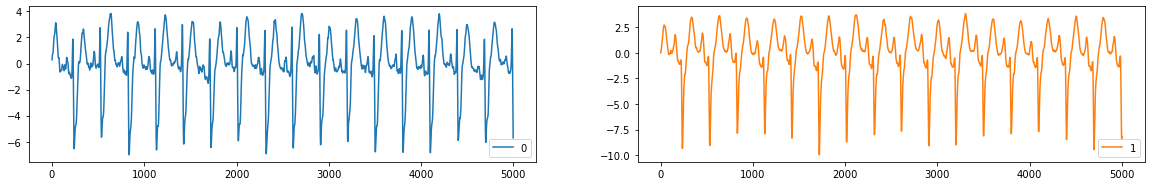

In [64]:
## median normalization
imp.reload(tfs)
    
ecg_tensor = TSTensor(X[0:16,:,0:5000])
ecg_tensor = tfs.NormMedian()(ecg_tensor)
fig = pd.DataFrame(ecg_tensor[0,0:2]).T.plot.line(subplots = True,layout=(6,2), figsize=(20,20))

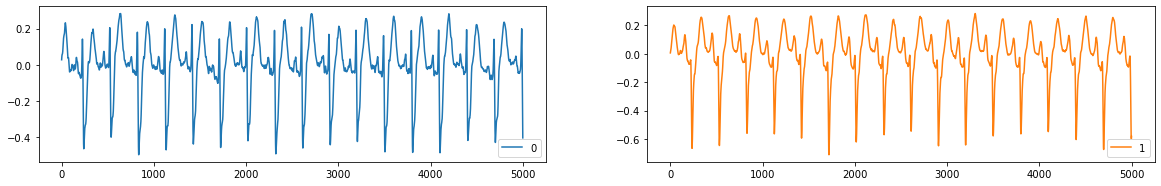

In [75]:
## decimal scaling
ecg_tensor = TSTensor(X[0:16,:,0:5000])
ecg_tensor = tfs.NormDecimalScaling()(ecg_tensor)
fig = pd.DataFrame(ecg_tensor[0,0:2]).T.plot.line(subplots = True,layout=(6,2), figsize=(20,20))

In [ ]:
## tanh
class NormTanh(Transform):
    # normalize by y = x/(10**log(max))
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
    def encodes(self, output: TSTensor):
        for i in range(len(output)):
            print(10**torch.floor(torch.log10(output[i].max())))
            output[i] = (output[i])/10**torch.floor(torch.log10(output[i].max()))
        return output

ecg_tensor = TSTensor(X[0:16,:,0:5000])
ecg_tensor = NormDecimalScaling()(ecg_tensor)
fig = pd.DataFrame(ecg_tensor[0,0:2]).T.plot.line(subplots = True,layout=(6,2), figsize=(20,20))

In [ ]:
class NormMedian(Transform):
    # normalize by dividing each ecg by its max value (each lead divided by max value of entire ecg)
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
    def encodes(self, output: TSTensor):
        for i in range(len(output)):
            output[i] = output[i]/output[i].max() # this should probably be absolute value
        return output

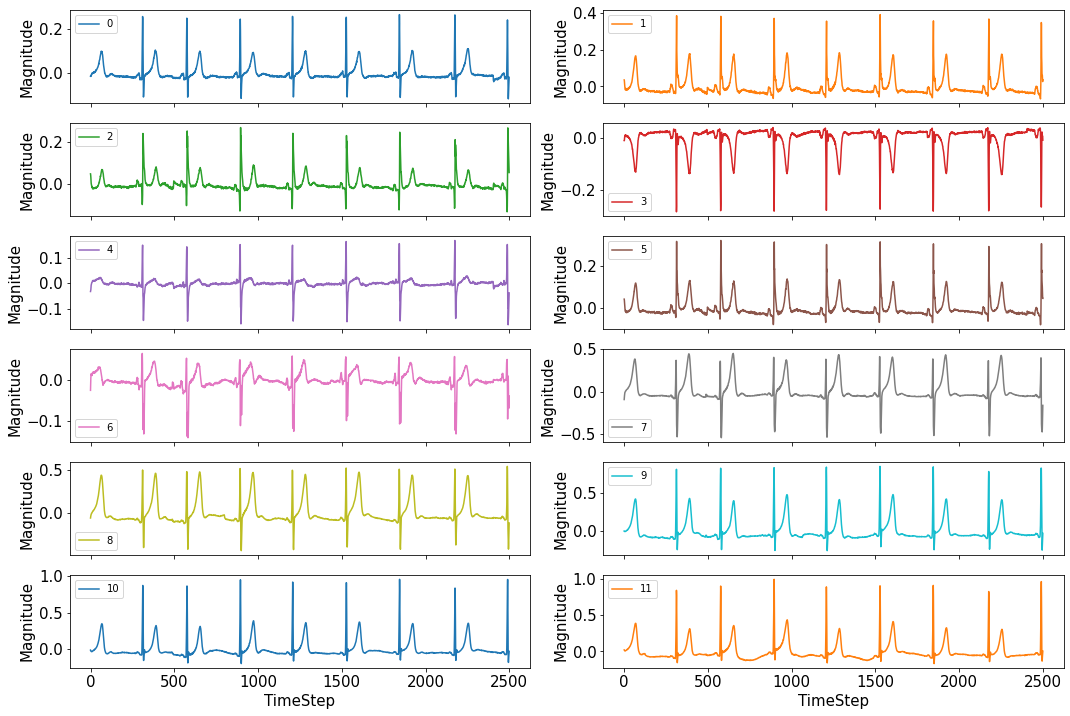

In [6]:
# raw
ecg_tensor = TSTensor(X[0:60,:,0:5000])
ecg_tensor = tfs.Normalize()(ecg_tensor)
ecg_tensor = tfs.Scale(scale_factor=sf,)(ecg_tensor)
ecg_tensor = tfs.BandPass(int(sf*500),low_cut=45, high_cut=0,leads=12,)(ecg_tensor)
ecg_tensor = tfs.RandomShift(0.5).encodes(ecg_tensor)
transformed_ecg = pd.DataFrame(ecg_tensor[45].cpu()).T
# transformed_ecg.columns = ["I","II"]
# modify plot and save
transformed_ecg.plot.line(subplots = True,layout=(6,2), figsize=(15,10))
for ax in plt.gcf().axes:
    ax.tick_params( which='both', labelsize=15)
    ax.set_ylabel("Magnitude", fontsize = 15)
    ax.set_xlabel("TimeStep", fontsize = 15)
    ax.legend(fontsize = 10,loc=False)
plt.tight_layout()
plt.savefig("images/raw.pdf")

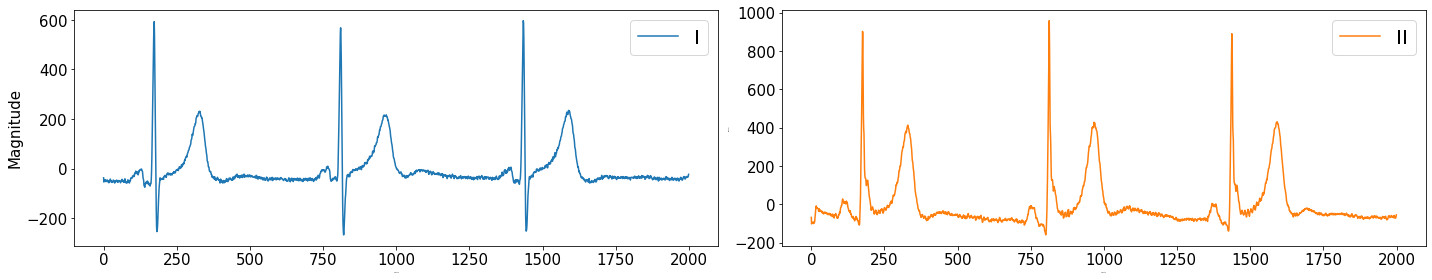

In [433]:
# raw
ecg_tensor = TSTensor(X[0:60,:,0:2000])
sf = 0.5
transformed_ecg = pd.DataFrame(ecg_tensor[45].cpu()[0:2]).T
transformed_ecg.columns = ["I","II"]
# modify plot and save
transformed_ecg.plot.line(subplots = True,layout=(1,2), figsize=(20,4))
for ax in plt.gcf().axes:
    ax.tick_params( which='both', labelsize=15)
    ax.set_ylabel("Magnitude", fontsize = 0)
    ax.set_xlabel("TimeStep", fontsize = 0)
    ax.legend(fontsize = 20,loc="upper right")
ax = plt.gcf().axes[0]
ax.set_ylabel("Magnitude", fontsize = 15)
plt.tight_layout()
# plt.savefig("images/raw.pdf")



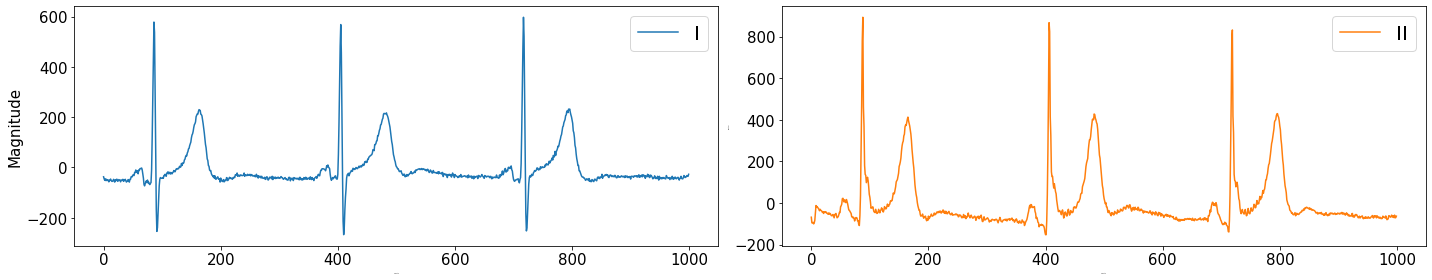

In [427]:
# sc
ecg_tensor = TSTensor(X[0:60,:,0:2000])
sf = 0.5
ecg_tensor = tfs.Scale(scale_factor=sf,)(ecg_tensor)
transformed_ecg = pd.DataFrame(ecg_tensor[45].cpu()[0:2]).T
transformed_ecg.columns = ["I","II"]
# modify plot and save
transformed_ecg.plot.line(subplots = True,layout=(1,2), figsize=(20,4))
for ax in plt.gcf().axes:
    ax.tick_params( which='both', labelsize=15)
    ax.set_ylabel("Magnitude", fontsize = 0)
    ax.set_xlabel("TimeStep", fontsize = 0)
    ax.legend(fontsize = 20,loc="upper right")
ax = plt.gcf().axes[0]
ax.set_ylabel("Magnitude", fontsize = 15)
plt.tight_layout()
plt.savefig("images/sc.pdf")



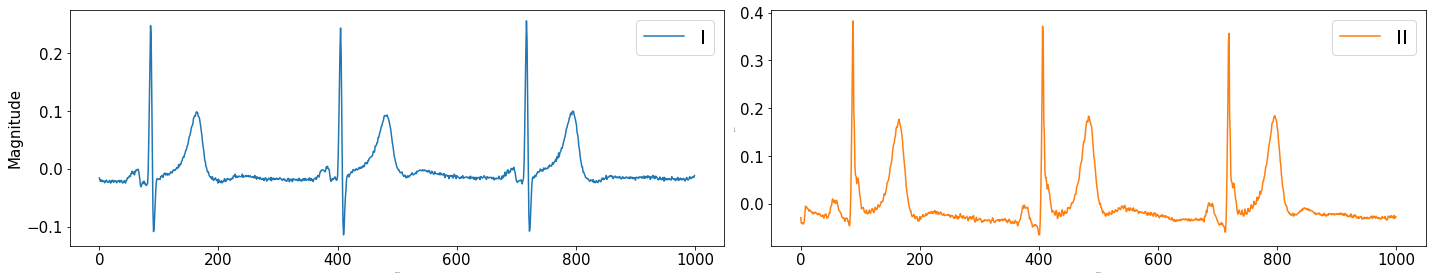

In [440]:
# sc-n
ecg_tensor = TSTensor(X[0:60,:,0:2000])
sf = 0.5
ecg_tensor = tfs.Scale(scale_factor=sf,)(ecg_tensor)
ecg_tensor = tfs.Normalize()(ecg_tensor)
transformed_ecg = pd.DataFrame(ecg_tensor[45].cpu()[0:2]).T
transformed_ecg.columns = ["I","II"]
# modify plot and save
transformed_ecg.plot.line(subplots = True,layout=(1,2), figsize=(20,4))
for ax in plt.gcf().axes:
    ax.tick_params( which='both', labelsize=15)
    ax.set_ylabel("Magnitude", fontsize = 0)
    ax.set_xlabel("TimeStep", fontsize = 0)
    ax.legend(fontsize = 20,loc="upper right")
ax = plt.gcf().axes[0]
ax.set_ylabel("Magnitude", fontsize = 15)
plt.tight_layout()
# plt.savefig("images/sc-n.pdf")



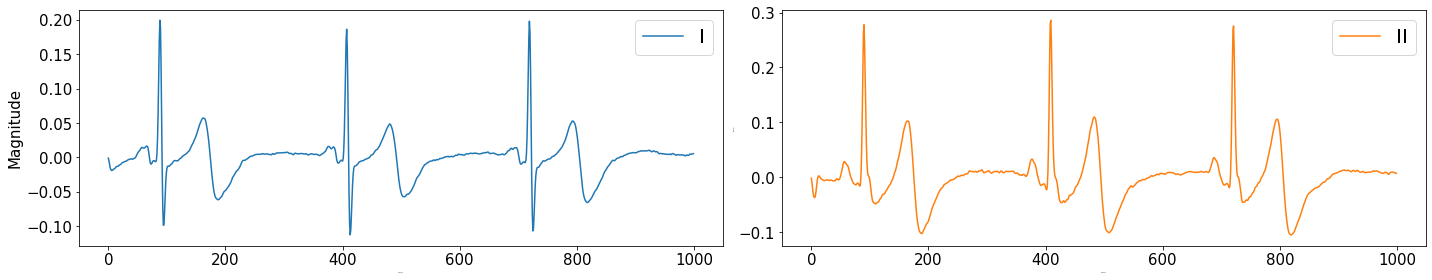

In [441]:
# sc-n-bp
ecg_tensor = TSTensor(X[0:60,:,0:2000])
sf = 0.5
ecg_tensor = tfs.Scale(scale_factor=sf,)(ecg_tensor)
ecg_tensor = tfs.Normalize()(ecg_tensor)
ecg_tensor = tfs.BandPass(int(sf*500),low_cut=45, high_cut=1,leads=12,)(ecg_tensor)
transformed_ecg = pd.DataFrame(ecg_tensor[45].cpu()[0:2]).T
transformed_ecg.columns = ["I","II"]
# modify plot and save
transformed_ecg.plot.line(subplots = True,layout=(1,2), figsize=(20,4))
for ax in plt.gcf().axes:
    ax.tick_params( which='both', labelsize=15)
    ax.set_ylabel("Magnitude", fontsize = 0)
    ax.set_xlabel("TimeStep", fontsize = 0)
    ax.legend(fontsize = 20,loc="upper right")
ax = plt.gcf().axes[0]
ax.set_ylabel("Magnitude", fontsize = 15)
plt.tight_layout()
plt.savefig("images/sc-n-bp.pdf")



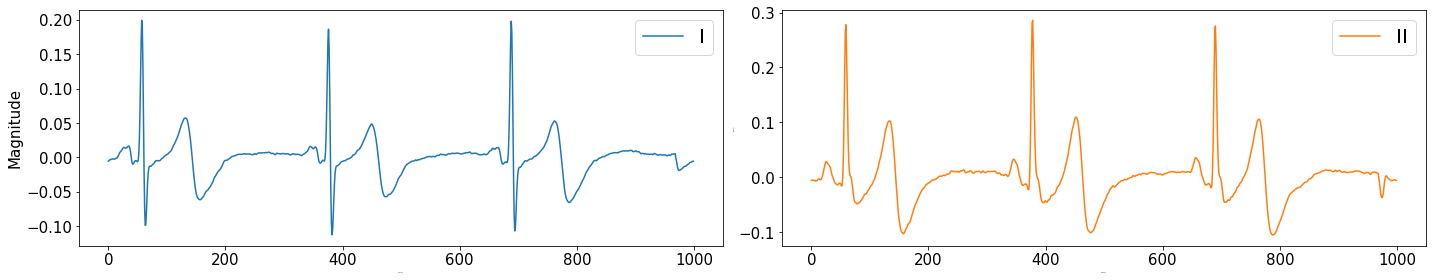

In [442]:
# sc-n-bp-sh
ecg_tensor = TSTensor(X[0:60,:,0:2000])
sf = 0.5
ecg_tensor = tfs.Scale(scale_factor=sf,)(ecg_tensor)
ecg_tensor = tfs.Normalize()(ecg_tensor)
ecg_tensor = tfs.BandPass(int(sf*500),low_cut=25, high_cut=1,leads=12,)(ecg_tensor)
ecg_tensor = tfs.RandomShift(0.5).encodes(ecg_tensor)
transformed_ecg = pd.DataFrame(ecg_tensor[45].cpu()[0:2]).T
transformed_ecg.columns = ["I","II"]
# modify plot and save
transformed_ecg.plot.line(subplots = True,layout=(1,2), figsize=(20,4))
for ax in plt.gcf().axes:
    ax.tick_params( which='both', labelsize=15)
    ax.set_ylabel("Magnitude", fontsize = 0)
    ax.set_xlabel("TimeStep", fontsize = 0)
    ax.legend(fontsize = 20,loc="upper right")
ax = plt.gcf().axes[0]
ax.set_ylabel("Magnitude", fontsize = 15)
plt.tight_layout()
# plt.savefig("images/sc-n-bp-sh.pdf")

